In [30]:
import pandas as pd
import numpy as np
import scipy
from pykalman.pykalman import *
import control

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='white', font_scale=1.5)
from statannotations.Annotator import Annotator
import statsmodels.formula.api as smf
import statsmodels as stats

import prep_emotioncon 
import emotioncon_modelling
import emotioncon_stats
import auxiliary

In [31]:
emo = emotioncon_modelling.Modelling()
emostats = emotioncon_stats.Statistics()
prep = prep_emotioncon.PrepEmotioncon()
aux = auxiliary.Auxiliary()
attention_cr = np.array([1, 0, 0, 1, 1, 1, 1, 0, 0, 0])
mood_categories = ['disgusted', 'amused', 'calm', 'anxious', 'sad']
filepath = '../'
data = np.load(filepath + 'results/data_experiment.npy',allow_pickle='TRUE')
savefig = True
palette= {0: "plum", 1: "purple", 2: "lightgrey", 3: "grey"}

In [32]:
# make inputs ready
input_df = pd.read_csv(filepath + 'experiment/public/prep/videosForExperiment.csv')
inp_dummies = pd.get_dummies(input_df['category'])
inp_dummies = inp_dummies.reindex(columns=['Disgust', 'Amusement', 'Calmness', 'Anxiety', 'Sadness'])
inp = inp_dummies.values
inp = np.vstack([np.zeros(np.shape(inp)[1]), inp, np.zeros(np.shape(inp)[1]), inp])

In [33]:
data = np.load(filepath + 'results/fit_experiment_cowenratings.npy',allow_pickle='TRUE')
df, mood_ratings, foo = prep.create_df_from_dict(data)
dynamics, controls = prep.rearrange_data_for_stats(data)
Nsj = len(data)
print('N = ' + str(Nsj))

N = 108


/Users/jolandamalamud/phd/papers/git/emotioncon_public/analyses/prep_emotioncon.py:119: RuntimeWarning: invalid value encountered in log
  dynamics['HL'][:,sj,k] = np.log(0.5) / np.log(e)
/Users/jolandamalamud/phd/papers/git/emotioncon_public/analyses/prep_emotioncon.py:119: RuntimeWarning: divide by zero encountered in log
  dynamics['HL'][:,sj,k] = np.log(0.5) / np.log(e)


In [34]:
# outlier Detection (IQR)
def detect_outlier(data):
    Q1 = np.percentile(data, 25)
    Q3 = np.percentile(data, 75)
    IQR = Q3 - Q1
    ex = np.where((data >= (Q1-1.5*IQR))&(data >= (Q3+1.5*IQR)))[0]
    print(Q1-1.5*IQR, Q3+1.5*IQR)
    return ex

/Users/jolandamalamud/opt/miniconda3/envs/emotioncon/lib/python3.8/site-packages/numpy/lib/histograms.py:852: ComplexWarning: Casting complex values to real discards the imaginary part
  indices = f_indices.astype(np.intp)
/Users/jolandamalamud/opt/miniconda3/envs/emotioncon/lib/python3.8/site-packages/matplotlib/transforms.py:775: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.asarray(points, float)


(0.6228510019491842+0j) (1.151944469483392+0j)
dynamics outliers: []
(-0.23706989479845308+0j) (3.2350217747003063+0j)
controllability outliers: [14]


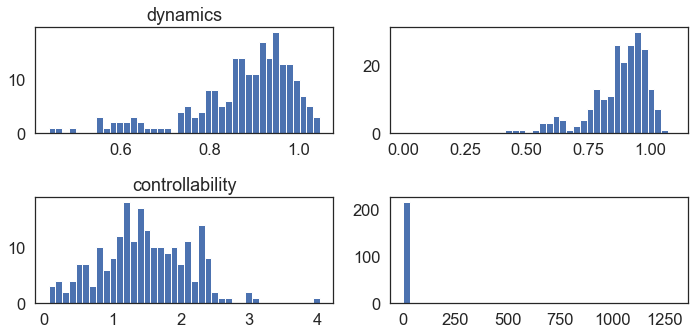

In [35]:
fig,ax = plt.subplots(2,2,figsize=(10,5))
cut = [1.1, 1300]
label = ['dynamics', 'controllability']
for j, i in enumerate([dynamics['val'][0,:,:], controls['val'][0,:,:]]):
    ax[j, 0].hist(i.flatten(), 40);
    ax[j, 0].set(title=label[j])
    ax[j, 1].hist(i.flatten(), 40, range=(0,cut[j]));
    print(label[j] + ' outliers: ' + str(detect_outlier(i)))
fig.tight_layout()

In [65]:
# outlier detection based on singular values in controllability matrix
ex = detect_outlier(dynamics['matrix'][:,:,:].flatten())
ex

(-0.7019416881719607+0j) (0.9606440700668231+0j)


array([  12,   13,   25,   64,   68,   69,   71,   82,   94,   95,   96,
         97,  109,  114,  180,  181,  185,  187,  189,  198,  207,  224,
        227,  240,  242,  248,  249,  258,  272,  273,  281,  290,  306,
        309,  334,  353,  403,  426,  433,  482,  483,  568,  585,  588,
        589,  591,  602,  603,  606,  646,  647,  684,  685,  759,  764,
        765,  771,  772,  799,  810,  820,  836,  837,  851,  870,  872,
        879,  892,  893,  909,  916,  940,  958,  959,  972,  992,  996,
        997, 1000, 1014, 1015, 1044, 1058, 1059, 1069, 1075, 1134, 1172,
       1186, 1202, 1203, 1274, 1275, 1289, 1326, 1338, 1339, 1345, 1416,
       1440, 1444, 1445, 1451, 1458, 1459, 1462, 1481, 1487, 1488, 1508,
       1512, 1513, 1525, 1532, 1593, 1620, 1621, 1686, 1687, 1705, 1725,
       1741, 1747, 1820, 1829, 1841, 1900, 1912, 1918, 1919, 1925, 1958,
       1968, 2071, 2094, 2095, 2115, 2124, 2129, 2135, 2157, 2204, 2243,
       2256, 2260, 2268, 2269, 2272, 2281, 2344, 23

In [62]:
max(dynamics['matrix'][:,:,:].flatten())

(7102.18751482265+0j)

In [63]:
ex = detect_outlier(dynamics['matrix'][:,:,:].flatten())
len(ex)/len(dynamics['matrix'][:,:,:].flatten()), ex

(-0.7019416881719607+0j) (0.9606440700668231+0j)


(0.07289719626168224,
 array([  12,   13,   25,   64,   68,   69,   71,   82,   94,   95,   96,
          97,  109,  114,  180,  181,  185,  187,  189,  198,  207,  224,
         227,  240,  242,  248,  249,  258,  272,  273,  281,  290,  306,
         309,  334,  353,  403,  426,  433,  482,  483,  568,  585,  588,
         589,  591,  602,  603,  606,  646,  647,  684,  685,  759,  764,
         765,  771,  772,  799,  810,  820,  836,  837,  851,  870,  872,
         879,  892,  893,  909,  916,  940,  958,  959,  972,  992,  996,
         997, 1000, 1014, 1015, 1044, 1058, 1059, 1069, 1075, 1134, 1172,
        1186, 1202, 1203, 1274, 1275, 1289, 1326, 1338, 1339, 1345, 1416,
        1440, 1444, 1445, 1451, 1458, 1459, 1462, 1481, 1487, 1488, 1508,
        1512, 1513, 1525, 1532, 1593, 1620, 1621, 1686, 1687, 1705, 1725,
        1741, 1747, 1820, 1829, 1841, 1900, 1912, 1918, 1919, 1925, 1958,
        1968, 2071, 2094, 2095, 2115, 2124, 2129, 2135, 2157, 2204, 2243,
        2256, 22

(array([  31.,   51.,  108.,  286., 1444., 2204.,  603.,  339.,  122.,
          51.]),
 array([-2. +0.j, -1.6+0.j, -1.2+0.j, -0.8+0.j, -0.4+0.j,  0. +0.j,
         0.4+0.j,  0.8+0.j,  1.2+0.j,  1.6+0.j,  2. +0.j]),
 <BarContainer object of 10 artists>)

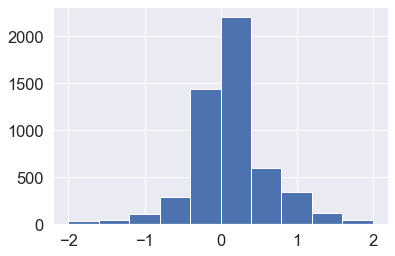

In [57]:
plt.hist(dynamics['matrix'].flatten(), range=(-2,2))

group: 0.0


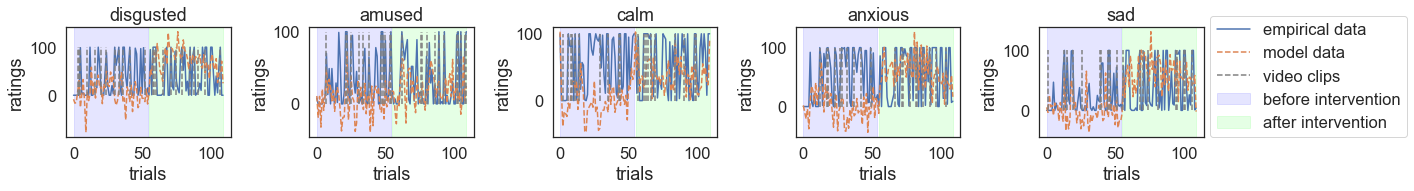

In [37]:
# excluded case
T = np.shape(data[0]['ratings'])[1]
for sj in ex:
    print('group: ' + str(df['randomized_condition'][sj]))
    fig, axs = plt.subplots(1,len(mood_categories),figsize=[20,3])
    x = np.empty((T,5))
    for t in range(2):
        inp_split = inp[t*int(T/2):t*int(T/2) + int(T/2),:]
        z, x[t*int(T/2):t*int(T/2) + int(T/2),:] = \
        data[sj]['results_split'][13+t].sample(int(T/2),  initial_state=data[sj]['ratings'][:,t*int(T/2)], \
                                                control_inputs=inp_split)
        
    for k in range(len(mood_categories)):
        axs[k].plot(mood_ratings[:,k,sj]);
        axs[k].plot(x[:,k], linestyle='--');
        axs[k].set_title(mood_categories[k]);
        axs[k].set_ylabel('ratings');
        axs[k].set_xlabel('trials');
        axs[k].vlines(np.where(inp[:,k]), ymin=0, ymax=100, color='gray', linestyles = 'dashed')
        ylim = axs[k].get_ylim()
        axs[k].add_patch(plt.Rectangle((0, ylim[0]), 54, np.abs(ylim[0]) + ylim[1], edgecolor=(0, 0, 1, 0.1), facecolor=(0, 0, 1, 0.1)))
        axs[k].add_patch(plt.Rectangle((55, ylim[0]), 54, np.abs(ylim[0]) + ylim[1], edgecolor=(0, 1, 0, 0.1), facecolor=(0, 1, 0, 0.1)))
    plt.legend(['empirical data','model data', 'video clips','before intervention', 'after intervention'], loc=(1.04,0))
    plt.tight_layout()
    plt.show()

In [38]:
# exclude outliers due to fit
data = np.delete(data,ex)
Nsj = len(data)
print('N = ' + str(Nsj))
np.save(filepath + 'results/fit_experiment_included.npy', data)
df, mood_ratings, foo = prep.create_df_from_dict(data)
dynamics, controls = prep.rearrange_data_for_stats(data)
print('number in distancing group: ' + str(df['randomized_condition'].sum()))

N = 107
number in distancing group: 57.0


/Users/jolandamalamud/phd/papers/git/emotioncon_public/analyses/prep_emotioncon.py:119: RuntimeWarning: invalid value encountered in log
  dynamics['HL'][:,sj,k] = np.log(0.5) / np.log(e)
/Users/jolandamalamud/phd/papers/git/emotioncon_public/analyses/prep_emotioncon.py:119: RuntimeWarning: divide by zero encountered in log
  dynamics['HL'][:,sj,k] = np.log(0.5) / np.log(e)


In [39]:
# norm of matrices as a measure of overall extrnal control or controllability
for d in [controls['matrix'], 'gramian']:
    for t in range(2):
        cc=[]
        for i in range(Nsj):
            if d == 'gramian': c = control.ctrb(dynamics['matrix'][:,:,i,t],controls['matrix'][:,:,i,t])
            else: c = d[:,:,i,t]
            cc.append(np.linalg.norm(c))
        for i in range(2):
            print('Gramian-norm group ' + str(i) + ': ' \
                  + str(np.round(np.nanmean(np.array(cc)[df['randomized_condition']==i]))) \
                  + '±' + str(np.round(np.nanstd(np.array(cc)[df['randomized_condition']==i]))))
        print(scipy.stats.mannwhitneyu(np.array(cc)[df['randomized_condition']==0],\
                                       np.array(cc)[df['randomized_condition']==1]))

Gramian-norm group 0: 2.0±1.0
Gramian-norm group 1: 2.0±1.0
MannwhitneyuResult(statistic=1754.0, pvalue=0.040254977078460444)
Gramian-norm group 0: 2.0±1.0
Gramian-norm group 1: 1.0±1.0
MannwhitneyuResult(statistic=2174.0, pvalue=2.960185575888256e-06)
Gramian-norm group 0: 2.0±1.0
Gramian-norm group 1: 2.0±1.0
MannwhitneyuResult(statistic=1722.0, pvalue=0.06412382462391382)
Gramian-norm group 0: 2.0±1.0
Gramian-norm group 1: 1.0±1.0
MannwhitneyuResult(statistic=2133.0, pvalue=9.981994468351361e-06)


/var/folders/5z/t44r3krd25sftrcjrj8j__4m0000gn/T/ipykernel_31056/580328917.py:6: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if d == 'gramian': c = control.ctrb(dynamics['matrix'][:,:,i,t],controls['matrix'][:,:,i,t])
/Users/jolandamalamud/opt/miniconda3/envs/emotioncon/lib/python3.8/site-packages/control/statesp.py:104: ComplexWarning: Casting complex values to real discards the imaginary part
  arr = np.array(data, dtype=float)


statistics done using absolute value of eigenvectors!
--

In [40]:
label = ['stability', 'controllability']
# before intervention measures should be similar for distancing and control condition
for k,p in enumerate([dynamics, controls]):
    print(20*'#' + '\n' + label[k] + ':')
    mm = []
    print('eigenvectors')
    for i in range(2):
        mm.append(np.nanmedian(p['absvec'][:,0,df['randomized_condition']==i,0],axis=1))
        mm.append(np.nanstd(p['absvec'][:,0,df['randomized_condition']==i,0],axis=1))
    df_new = pd.DataFrame(mm).T
    df_new.columns = ['mean control', 'std control', 'mean distancing', 'std distancing']
    df_new.index = mood_categories
    display(df_new)

    mm = []
    print('eigenvalues')
    for i in range(2):
        mm.append(np.real(np.nanmedian(p['val'][:,df['randomized_condition']==i,0],axis=1)))
        mm.append(np.real(np.nanstd(p['val'][:,df['randomized_condition']==i,0],axis=1)))
    df_new = pd.DataFrame(mm).T
    df_new.columns = ['mean control', 'std control', 'mean distancing', 'std distancing']
    df_new.index = [[str(i+1) + '.' for i in range(5)]]
    display(df_new)

####################
stability:
eigenvectors


,mean control,std control,mean distancing,std distancing
disgusted,0.174374,0.166750,0.136532,0.157821
amused,0.300353,0.221339,0.179149,0.203698
calm,0.698404,0.293460,0.746076,0.224837
anxious,0.300384,0.245550,0.228703,0.218605
sad,0.199323,0.195301,0.184636,0.179893


eigenvalues


,mean control,std control,mean distancing,std distancing
1.,0.863854,0.118171,0.903283,0.129918
2.,0.417834,0.237042,0.553820,0.241882
3.,0.183864,0.194884,0.239301,0.214367
4.,0.059792,0.178289,0.074029,0.216897
5.,-0.061609,0.207165,-0.039170,0.225701


####################
controllability:
eigenvectors


,mean control,std control,mean distancing,std distancing
disgusted,0.497116,0.222892,0.426984,0.211873
amused,0.345946,0.201124,0.271556,0.243397
calm,0.415538,0.171897,0.436924,0.224783
anxious,0.399586,0.177184,0.473472,0.233714
sad,0.431636,0.174375,0.361469,0.187573


eigenvalues


,mean control,std control,mean distancing,std distancing
1.,1.668280,0.479668,1.448910,0.594497
2.,0.860734,0.246190,0.822401,0.312176
3.,0.654101,0.217967,0.546129,0.254802
4.,0.502534,0.206888,0.357782,0.206567
5.,0.248944,0.180689,0.161364,0.159286


stability


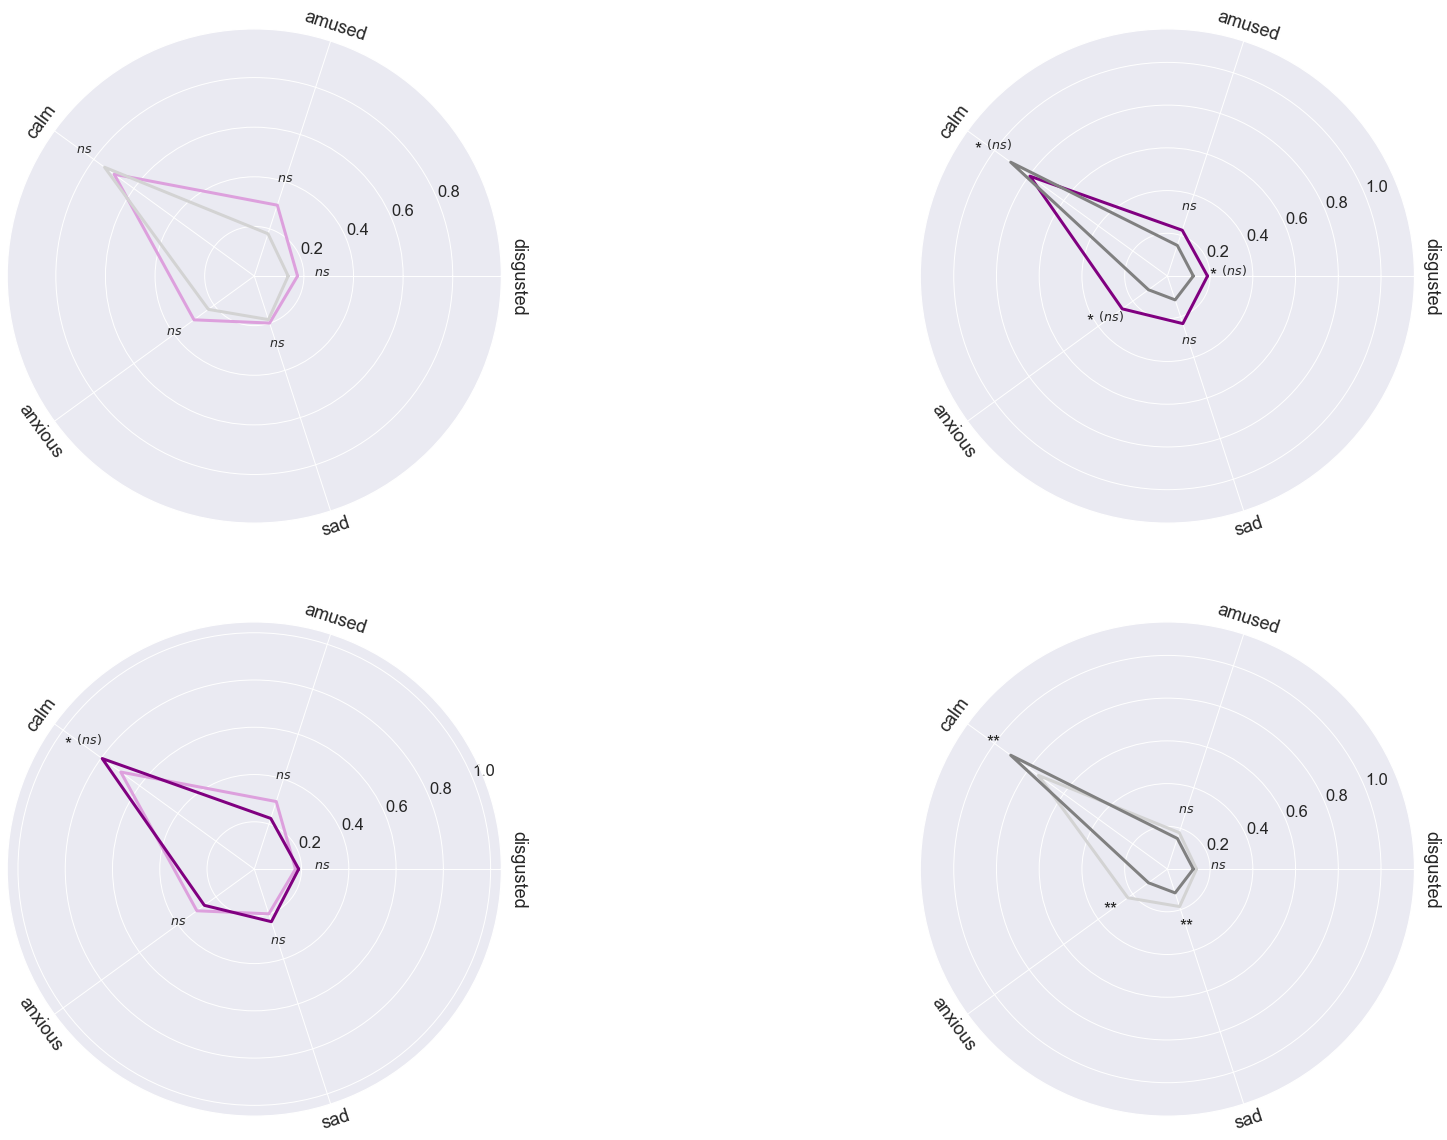

controllability


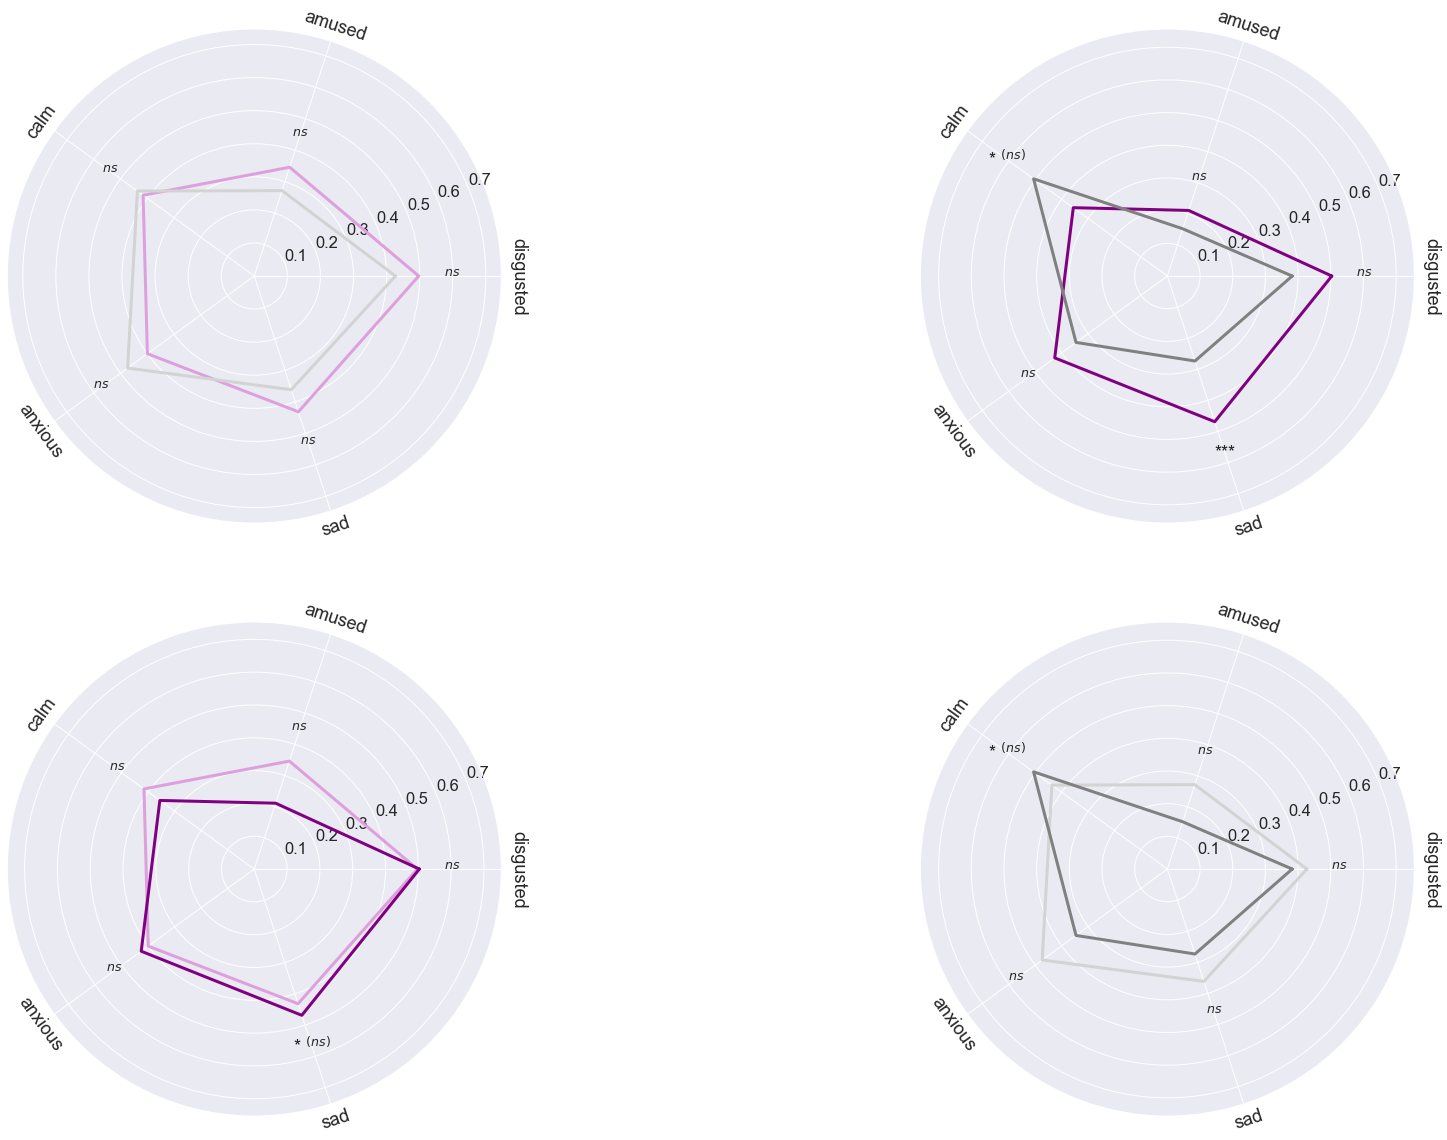

In [41]:
sns.set(font_scale=1.5)
data_label=['stability', 'controllability']
for j, d in enumerate([dynamics, controls]):
    print(data_label[j])
    plot_data = d['absvec'][:,0,:,:]
    fig = plt.figure(figsize=(30, 20))
    ax = plt.subplot(2,2,1, polar=True)
    palette= {0: "plum", 1: "purple", 2: "lightgrey", 3: "grey"}
    medians = np.full((len(mood_categories)+1, 4), np.nan)
    pvalues = np.full((len(mood_categories), 4), np.nan)
    x = np.linspace(0, 2 * np.pi, len(mood_categories)+1)
    for i in range(2):
        for m in range(5):
            pvalues[m,i] = scipy.stats.wilcoxon(plot_data[m,df['randomized_condition']==i,0].T, \
                                                    plot_data[m,df['randomized_condition']==i,1].T).pvalue
            pvalues[m,i] = stats.stats.multitest.multipletests(pvalues[m,i], method='bonferroni')[1]
        for t in range(2):
            tmp = np.nanmedian(plot_data[:,df['randomized_condition']==i,t],axis=1)
            medians[:,t + (i*2)] = np.append(tmp, tmp[0])
            pvalues[:,2+t] = scipy.stats.mannwhitneyu(plot_data[:,df['randomized_condition']==0,t].T, \
                                                plot_data[:,df['randomized_condition']==1,t].T).pvalue
            pvalues[:,2+t] = stats.stats.multitest.multipletests(pvalues[:,2+t], method='bonferroni')[1]

    aux.polar_plot(medians[:,[0,2]], mood_categories, [palette[0], palette[2]], \
               ax, plt, pval=list(pvalues[:,2]))

    ax = plt.subplot(2,2,2, polar=True)
    aux.polar_plot(medians[:,[1,3]], mood_categories, [palette[1], palette[3]], \
               ax, plt, pval=list(pvalues[:,3]))
    ax = plt.subplot(2,2,3, polar=True)
    aux.polar_plot(medians[:,[0,1]], mood_categories, [palette[0], palette[1]], \
               ax, plt, pval=list(pvalues[:,0]))
    ax = plt.subplot(2,2,4, polar=True)
    aux.polar_plot(medians[:,[2,3]], mood_categories, [palette[2], palette[3]], \
               ax, plt, pval=list(pvalues[:,1]))
    plt.show()
#     plt.savefig('/Users/jolandamalamud/Desktop/' + data_label[j] + '_eigenvector.png', bbox_inches='tight')

[[ 0.224  1.208 -1.885  1.184  0.42   2.853  1.561 -2.794  2.717  2.505]
 [ 0.823  0.23   0.062  0.239  0.676  0.005  0.122  0.006  0.008  0.014]]
[[ 1.434e+00  3.280e-01 -6.280e-01 -4.910e-01  1.431e+00  2.371e+00
   5.280e-01 -3.255e+00  1.079e+00  4.149e+00]
 [ 1.550e-01  7.440e-01  5.310e-01  6.240e-01  1.550e-01  2.000e-02
   5.990e-01  2.000e-03  2.830e-01  0.000e+00]]


,T2,Fstats,pvalue,T2,Fstats,pvalue
before intervention,6.34,1.22,0.306,8.04,1.55,0.182
after intervention,14.92,2.87,0.018,23.60,4.54,< 0.001
change (after - before),11.09,2.13,0.067,9.32,1.79,0.121


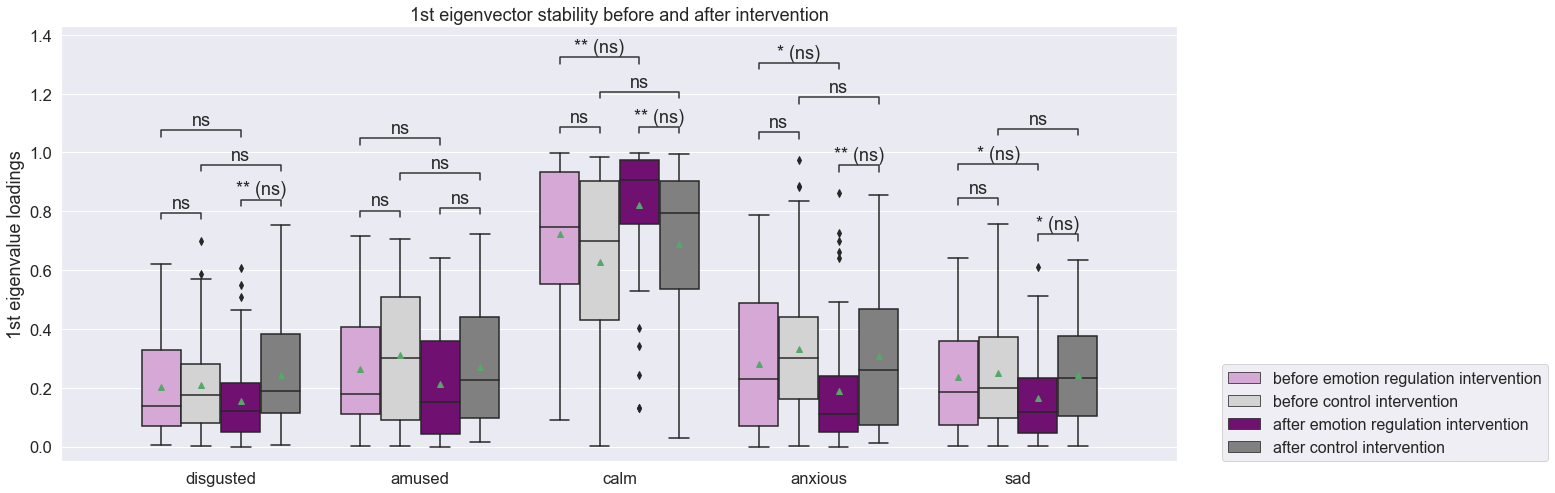

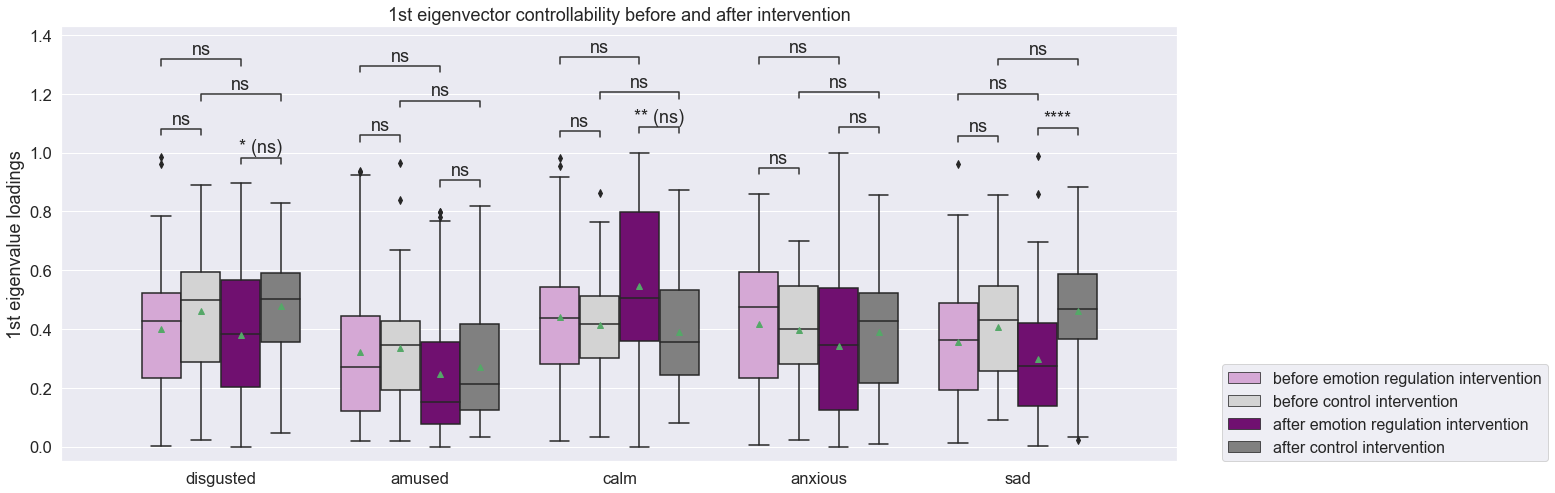

In [42]:
# compare first eigenvector of controllability & stability after intervention
pairs = []
for t in range(2):
    for i in mood_categories:
        pairs.append([(i, 0+t), (i, 2+t)])
        pairs.append([(i, t+(t*1)), (i, t+(t*1)+1)])
        
df_stats_both = pd.DataFrame()
for j, i in enumerate([dynamics, controls]):
    df_stats, pvalues, tvalues = emostats.stats_group_difference(i['absvec'][:,0,:,:], df)
    df_plot = emostats.make_df(i['absvec'][:,0,:,:], df, mood_categories)
    fig, ax = plt.subplots(figsize=(20,8))
    fig, ax = emostats.plot_group_difference(df=df_plot, data_labels=mood_categories, \
                                             data_name='1st eigenvector ' + label[j] , pairs=pairs, fig=fig, ax=ax)
    ax.set(ylabel='1st eigenvalue loadings')
    df_stats_both = pd.concat((df_stats_both, df_stats), axis=1)
    print(np.round([tvalues,pvalues],3))
#     if savefig: plt.savefig('/Users/jolandamalamud/Desktop/' + label[j] + 'vec.png', bbox_inches='tight')

display(df_stats_both)
# print(df_stats_both.to_latex())
# import dataframe_image as dfi
# dfi.export(df_stats_both, '/Users/jolandamalamud/Desktop/mean_stats.png')

In [43]:
# check interaction using MANOVA
from statsmodels.multivariate.manova import MANOVA
for j, p in enumerate([dynamics, controls]):
    print(['stability', 'controllability'][j])
    df_test = pd.DataFrame()
    for t in range(2):
        df_test = pd.concat((df_test, pd.DataFrame(p['absvec'][:,0,:,t])),axis=1, \
                            ignore_index=True)
    df_test = df_test.T
    df_test.columns = mood_categories
    df_test['time'] = np.concatenate((np.zeros([Nsj,1]),np.ones([Nsj,1])))
    df_test['condition'] = np.concatenate((df['randomized_condition'].values,df['randomized_condition'].values))
    fit = MANOVA.from_formula('disgusted + amused + calm + anxious + sad ~ condition*time', data=df_test)
    display(fit.mv_test().summary_frame)
    print('single stats using Mann Withney U test:')
    for i in range(5):
        dd = p['absvec'][i,0,:,1]
        print(scipy.stats.mannwhitneyu(dd[df['randomized_condition']==0],dd[df['randomized_condition']==1]))
    print(100*'-')

stability


Value Num DF Den DF     F Value  \
Effect         Statistic                                                     
Intercept      Wilks' lambda            0.046796      5  206.0  839.219231   
               Pillai's trace           0.953204    5.0  206.0  839.219231   
               Hotelling-Lawley trace  20.369399      5  206.0  839.219231   
               Roy's greatest root     20.369399      5    206  839.219231   
condition      Wilks' lambda            0.968553      5  206.0    1.337693   
               Pillai's trace           0.031447    5.0  206.0    1.337693   
               Hotelling-Lawley trace   0.032468      5  206.0    1.337693   
               Roy's greatest root      0.032468      5    206    1.337693   
time           Wilks' lambda             0.96445      5  206.0    1.518631   
               Pillai's trace            0.03555    5.0  206.0    1.518631   
               Hotelling-Lawley trace    0.03686      5  206.0    1.518631   
               Roy's greatest root       0.03686      5    206    1.518631   
condition:time Wilks' lambda            0.967818      5  206.0    1.369972   
               Pillai's trace           0.032182    5.0  206.0    1.369972   
               Hotelling-Lawley trace   0.033252      5  206.0    1.369972   
               Roy's greatest root      0.033252      5    206    1.369972   

                                         Pr > F  
Effect         Statistic                         
Intercept      Wilks' lambda                0.0  
               Pillai's trace               0.0  
               Hotelling-Lawley trace       0.0  
               Roy's greatest root          0.0  
condition      Wilks' lambda           0.249656  
               Pillai's trace          0.249656  
               Hotelling-Lawley trace  0.249656  
               Roy's greatest root     0.249656  
time           Wilks' lambda           0.185354  
               Pillai's trace          0.185354  
               Hotelling-Lawley trace  0.185354  
               Roy's greatest root     0.185354  
condition:time Wilks' lambda           0.236951  
               Pillai's trace          0.236951  
               Hotelling-Lawley trace  0.236951  
               Roy's greatest root     0.236951

single stats using Mann Withney U test:
MannwhitneyuResult(statistic=1868.0, pvalue=0.00572853762085974)
MannwhitneyuResult(statistic=1687.0, pvalue=0.10251500876585751)
MannwhitneyuResult(statistic=942.0, pvalue=0.0025894809491691538)
MannwhitneyuResult(statistic=1879.0, pvalue=0.00463141402626084)
MannwhitneyuResult(statistic=1822.0, pvalue=0.013297209694010765)
----------------------------------------------------------------------------------------------------
controllability


Value Num DF Den DF     F Value  \
Effect         Statistic                                                     
Intercept      Wilks' lambda            0.050411      5  206.0  776.082991   
               Pillai's trace           0.949589    5.0  206.0  776.082991   
               Hotelling-Lawley trace  18.836966      5  206.0  776.082991   
               Roy's greatest root     18.836966      5    206  776.082991   
condition      Wilks' lambda            0.973607      5  206.0    1.116851   
               Pillai's trace           0.026393    5.0  206.0    1.116851   
               Hotelling-Lawley trace   0.027108      5  206.0    1.116851   
               Roy's greatest root      0.027108      5    206    1.116851   
time           Wilks' lambda            0.981188      5  206.0    0.789912   
               Pillai's trace           0.018812    5.0  206.0    0.789912   
               Hotelling-Lawley trace   0.019173      5  206.0    0.789912   
               Roy's greatest root      0.019173      5    206    0.789912   
condition:time Wilks' lambda            0.963669      5  206.0    1.553251   
               Pillai's trace           0.036331    5.0  206.0    1.553251   
               Hotelling-Lawley trace     0.0377      5  206.0    1.553251   
               Roy's greatest root        0.0377      5    206    1.553251   

                                         Pr > F  
Effect         Statistic                         
Intercept      Wilks' lambda                0.0  
               Pillai's trace               0.0  
               Hotelling-Lawley trace       0.0  
               Roy's greatest root          0.0  
condition      Wilks' lambda           0.352513  
               Pillai's trace          0.352513  
               Hotelling-Lawley trace  0.352513  
               Roy's greatest root     0.352513  
time           Wilks' lambda           0.558009  
               Pillai's trace          0.558009  
               Hotelling-Lawley trace  0.558009  
               Roy's greatest root     0.558009  
condition:time Wilks' lambda            0.17486  
               Pillai's trace           0.17486  
               Hotelling-Lawley trace   0.17486  
               Roy's greatest root      0.17486

single stats using Mann Withney U test:
MannwhitneyuResult(statistic=1793.0, pvalue=0.02175403704154494)
MannwhitneyuResult(statistic=1607.0, pvalue=0.2571013763346064)
MannwhitneyuResult(statistic=944.0, pvalue=0.0026980544192586743)
MannwhitneyuResult(statistic=1622.0, pvalue=0.21984987414638846)
MannwhitneyuResult(statistic=2106.0, pvalue=2.147483584442102e-05)
----------------------------------------------------------------------------------------------------


In [15]:
# statistics table including group comparisons and before and after comparisons 
print('multiple comparison: ' + str(0.05/15))
df_stats = pd.DataFrame()
for j in [dynamics['absvec'][:,0,:,:], controls['absvec'][:,0,:,:]]:
    pval, statistics = [np.empty((4,5)) for i in range(2)]
    mm1, mm2 = [np.empty((4,5), dtype=object) for i in range(2)]
    
    for t in range(2):
        for i in range(5):
            dd = j[i,:,t]
            statistics[t,i] = scipy.stats.mannwhitneyu(dd[df['randomized_condition']==0],\
                                                       dd[df['randomized_condition']==1]).statistic
            pval[t,i] = scipy.stats.mannwhitneyu(dd[df['randomized_condition']==0],\
                                                 dd[df['randomized_condition']==1]).pvalue
            mm1[t,i] = str((np.round(np.nanmean(dd[df['randomized_condition']==0]),2))) + '$\pm$' + \
                       str((np.round(np.nanstd(dd[df['randomized_condition']==0]),2)))
            mm2[t,i] = str((np.round(np.nanmean(dd[df['randomized_condition']==1]),2))) + '$\pm$' + \
                       str((np.round(np.nanstd(dd[df['randomized_condition']==1]),2)))
    for g in range(2):
        for i in range(5):
            dd = j[i,:,:]
            statistics[g+2,i] = scipy.stats.wilcoxon(dd[df['randomized_condition']==g,0],\
                                                   dd[df['randomized_condition']==g,1]).statistic
            pval[g+2,i] = scipy.stats.wilcoxon(dd[df['randomized_condition']==g,0],\
                                             dd[df['randomized_condition']==g,1]).pvalue
            mm1[g+2,i] = str((np.round(np.nanmean(dd[df['randomized_condition']==g,0]),2))) + '$\pm$' + \
                       str((np.round(np.nanstd(dd[df['randomized_condition']==g,0]),2)))
            mm2[g+2,i] = str((np.round(np.nanmean(dd[df['randomized_condition']==g,1]),2))) + '$\pm$' + \
                       str((np.round(np.nanstd(dd[df['randomized_condition']==g,1]),2)))
    statsarray = np.empty((4,20),dtype=object)
    for i in range(4):
        for j in range(5):
            statsarray[i,j*4] = mm1[i,j]
            statsarray[i,j*4+1] = mm2[i,j]
            statsarray[i,j*4+2] = np.round(statistics[i,j],2)
            if pval[i,j] < 0.001:statsarray[i,j*4+3] = '$<$0.001'
            else: statsarray[i,j*4+3] = np.round(pval[i,j],3)
    header = [np.repeat(mood_categories,4), len(mood_categories) * ['v1 (M$\pm$SD)', 'v2 (M$\pm$SD)', 'statistics', 'pvalue']]
    df_stats = pd.concat((df_stats, pd.DataFrame(statsarray, index=['group comparison at t=0', 'group comparison t=1', \
                            'before vs after g=0', 'before vs after g=1'], columns=header)))
# tab=[]
# for i in range(4):
#     tab.append(np.round(np.array([np.min(statistics[i,:]), np.max(statistics[i,:]), \
#                              np.max(pval[i,:]), np.min(pval[i,:])]),3))
# pd.DataFrame(tab, index=['group comparison t=0', 'group comparison t=0', \
#                         'before vs after g=0', 'before vs after g=1'], \
#              columns=['min stats', 'max stats', 'max pval', 'min pval'])
df_stats.index =  [np.repeat(['stability', 'controllability'], 4), df_stats.index]
df_stats.round(2)
# print(df_stats.round(2).to_latex(escape=False))

multiple comparison: 0.0033333333333333335


disgusted                 \
                                         v1 (M$\pm$SD)  v2 (M$\pm$SD)   
stability       group comparison at t=0   0.25$\pm$0.2  0.22$\pm$0.17   
                group comparison t=1     0.26$\pm$0.18  0.18$\pm$0.15   
                before vs after g=0       0.25$\pm$0.2  0.26$\pm$0.18   
                before vs after g=1      0.22$\pm$0.17  0.18$\pm$0.15   
controllability group comparison at t=0  0.47$\pm$0.21  0.44$\pm$0.22   
                group comparison t=1     0.49$\pm$0.19  0.39$\pm$0.24   
                before vs after g=0      0.47$\pm$0.21  0.49$\pm$0.19   
                before vs after g=1      0.44$\pm$0.22  0.39$\pm$0.24   

                                                                  amused  \
                                        statistics pvalue  v1 (M$\pm$SD)   
stability       group comparison at t=0     1553.0  0.542  0.39$\pm$0.22   
                group comparison t=1        1857.0  0.013  0.35$\pm$0.24   
                before vs after g=0          595.0  0.524  0.39$\pm$0.22   
                before vs after g=1          703.0  0.326  0.33$\pm$0.22   
controllability group comparison at t=0     1599.0  0.372  0.37$\pm$0.16   
                group comparison t=1        1783.0  0.043  0.36$\pm$0.18   
                before vs after g=0          621.0  0.694  0.37$\pm$0.16   
                before vs after g=1          644.0  0.147  0.34$\pm$0.23   

                                                                          \
                                         v2 (M$\pm$SD) statistics pvalue   
stability       group comparison at t=0  0.33$\pm$0.22     1684.0  0.157   
                group comparison t=1     0.25$\pm$0.21     1812.0  0.028   
                before vs after g=0      0.35$\pm$0.24      532.0  0.219   
                before vs after g=1      0.25$\pm$0.21      506.0  0.011   
controllability group comparison at t=0  0.34$\pm$0.23     1702.0  0.127   
                group comparison t=1      0.3$\pm$0.24     1752.0  0.067   
                before vs after g=0      0.36$\pm$0.18      659.0   0.97   
                before vs after g=1       0.3$\pm$0.24      615.0  0.093   

                                                  calm                 \
                                         v1 (M$\pm$SD)  v2 (M$\pm$SD)   
stability       group comparison at t=0  0.56$\pm$0.29  0.69$\pm$0.22   
                group comparison t=1     0.64$\pm$0.26  0.77$\pm$0.24   
                before vs after g=0      0.56$\pm$0.29  0.64$\pm$0.26   
                before vs after g=1      0.69$\pm$0.22  0.77$\pm$0.24   
controllability group comparison at t=0  0.42$\pm$0.17  0.42$\pm$0.21   
                group comparison t=1     0.36$\pm$0.19  0.49$\pm$0.28   
                before vs after g=0      0.42$\pm$0.17  0.36$\pm$0.19   
                before vs after g=1      0.42$\pm$0.21  0.49$\pm$0.28   

                                                                 anxious  \
                                        statistics pvalue  v1 (M$\pm$SD)   
stability       group comparison at t=0     1107.0  0.033  0.33$\pm$0.26   
                group comparison t=1         988.0  0.004  0.28$\pm$0.22   
                before vs after g=0          529.0  0.209  0.33$\pm$0.26   
                before vs after g=1          473.0  0.005  0.29$\pm$0.21   
controllability group comparison at t=0     1467.0  0.936  0.44$\pm$0.19   
                group comparison t=1        1058.0  0.015  0.44$\pm$0.19   
                before vs after g=0          468.0  0.068  0.44$\pm$0.19   
                before vs after g=1          636.0   0.13  0.45$\pm$0.23   

                                                                          \
                                         v2 (M$\pm$SD) statistics pvalue   
stability       group comparison at t=0  0.29$\pm$0.21     1572.0  0.468   
                group comparison t=1      0.2$\pm$0.21     1800.0  0.033

In [16]:
# group comparison of eigenvalues after
for j, i in enumerate([controls, dynamics]):
    dd = i['val'][0,:,1]
    print(['stability', 'controllability'][j])
    print(scipy.stats.mannwhitneyu(dd[df['randomized_condition']==0],dd[df['randomized_condition']==1]))

stability
MannwhitneyuResult(statistic=2078.0, pvalue=0.00012299787527128242)
controllability
MannwhitneyuResult(statistic=1231.0, pvalue=0.1718825628038183)


In [17]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
for p in [dynamics, controls]:
    df_test = pd.DataFrame()
    for t in range(2):
        df_test = pd.concat((df_test, pd.DataFrame(np.real(p['val'][0,:,t]))),axis=0, \
                            ignore_index=True)
    df_test.columns = ['val']
    df_test['time'] = np.concatenate((np.zeros([Nsj,1]),np.ones([Nsj,1])))
    df_test['condition'] = np.concatenate((df['randomized_condition'].values,df['randomized_condition'].values))
    lm = ols('val ~ C(time)*C(condition)', \
             data=df_test).fit()
    table = sm.stats.anova_lm(lm, typ=2)    
    display(table)

,sum_sq,df,F,PR(>F)
C(time),0.112018,1.0,12.287747,0.000556
C(condition),0.027795,1.0,3.048962,0.082237
C(time):C(condition),0.002580,1.0,0.283035,0.595276
Residual,1.932647,212.0,NaN,NaN


,sum_sq,df,F,PR(>F)
C(time),5.043062,1.0,10.863331,0.001150
C(condition),6.867156,1.0,14.792638,0.000159
C(time):C(condition),2.204733,1.0,4.749248,0.030413
Residual,98.416319,212.0,NaN,NaN


[1.208e+03 1.760e-01]
[1.16e+03 9.90e-02]
[1.704e+03 8.200e-02]
[2065.    0.]


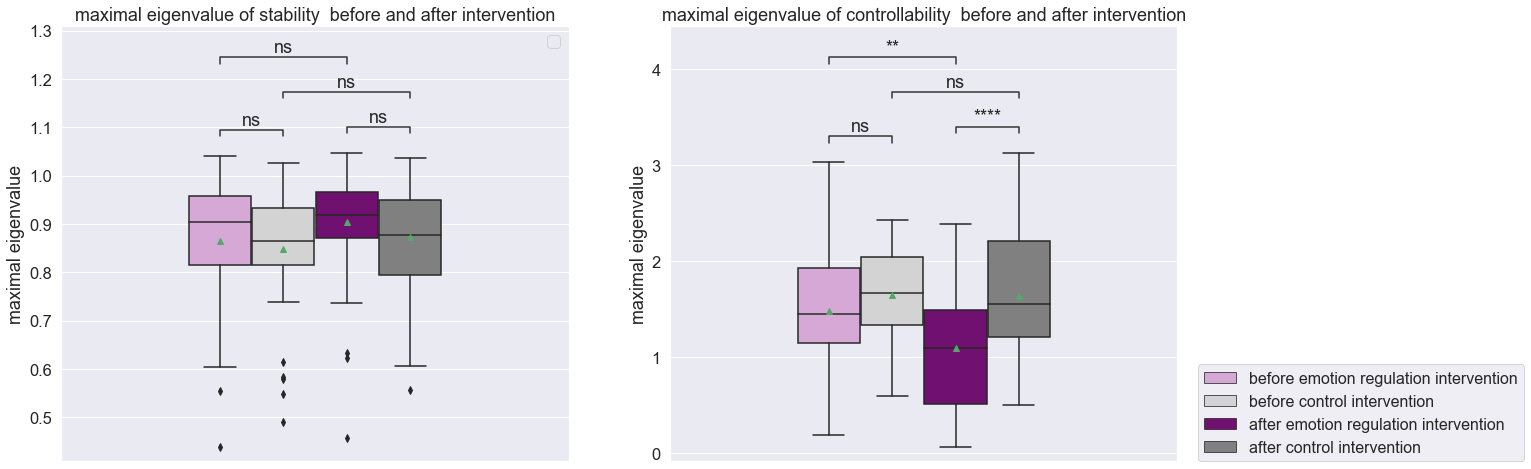

In [44]:
pairs = []
for t in range(2):
    pairs.append([('val', 0+t), ('val', 2+t)])
    pairs.append([('val', t+(t*1)), ('val', t+(t*1)+1)])
fig = plt.figure(figsize=(20,8))
for i,p in enumerate([dynamics, controls]):
    ax = fig.add_subplot(1,2,i+1)
    plot_data = np.abs(p['val'][0,:,:])
    pval = []
    for t in range(2):
        tstats = scipy.stats.mannwhitneyu(plot_data[df['randomized_condition']==0,t], \
                                           plot_data[df['randomized_condition']==1,t])
        pval.append(tstats[1])
        print(np.round(tstats,3))
    Nsj = len(df)
    tmp = pd.DataFrame(np.hstack((plot_data[:,0], plot_data[:,1])), columns=['val'])
    tmp['time'] = np.hstack((np.zeros(Nsj),np.ones(Nsj)))
    tmp['condition'] = 2*df['randomized_condition'].to_list()
    tmp['condition_time'] = tmp['time'] + tmp['condition'] * 2
    df_melted = tmp.melt(id_vars=['condition_time'], value_vars=['val'], value_name='rating', var_name='category')
    fig,ax = emostats.plot_group_difference(df=df_melted, pairs=pairs, data_labels=['eigenval'], \
                                           data_name='maximal eigenvalue of ' + label[i] + ' ', fig=fig, ax=ax)
    if i ==0: plt.legend([])
    ax.set(ylabel='maximal eigenvalue', xlabel='', xticklabels='')
#     plt.savefig('/Users/jolandamalamud/Desktop/' + label[i] + 'val.png', bbox_inches='tight')
#     plt.savefig(filepath + '/results/figures/' + label[i] + 'val.png', bbox_inches='tight')

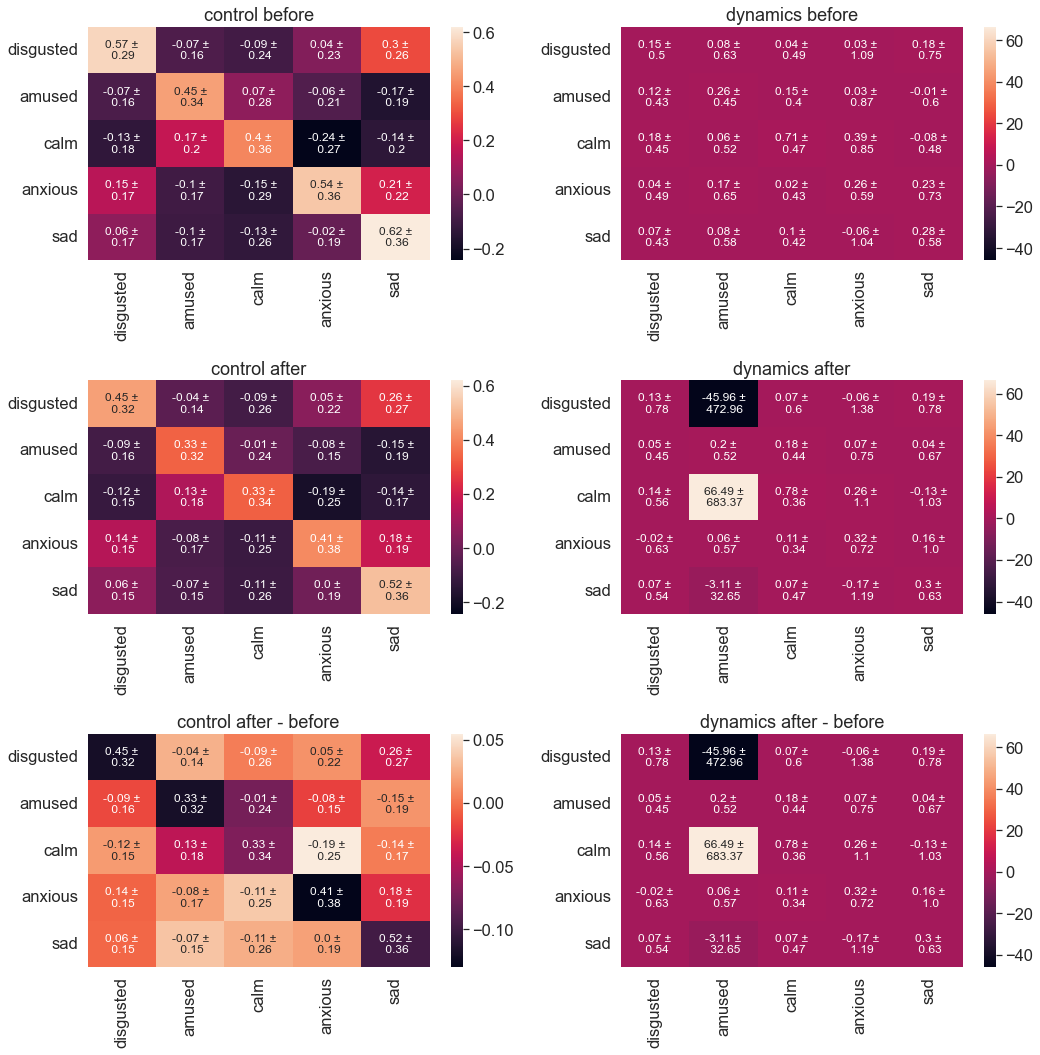

In [45]:
# average dynamics and control matrix all participants
aux.plot_matrices(controls, dynamics, np.ones(len(df))==1, mood_categories)

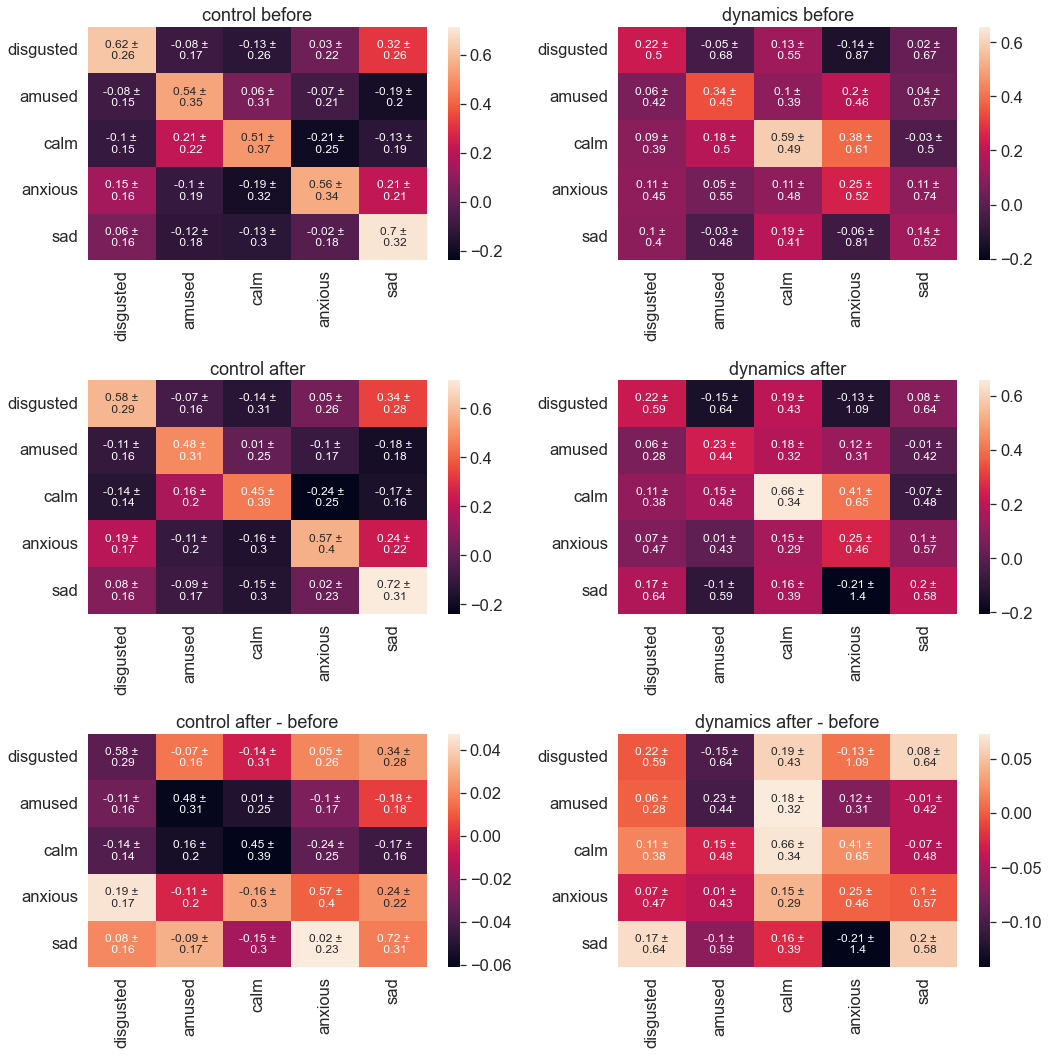

In [46]:
# average dynamics and control matrix only participants in distancing group
aux.plot_matrices(controls, dynamics, df['randomized_condition']==0, mood_categories)

----
Relation with symptoms
--

In [21]:
df_questionnaire = pd.read_csv('../results/questionnaire_data.csv',index_col=[0])
questionnaires = ['phq', 'gad', 'ders']
df_questionnaire = df_questionnaire.drop(index=ex).reset_index(drop=True)

In [22]:
# create dicts
var = 'val'
dict_data = dict()
for t in ['t1', 't2', 'change']:
    for i in [dynamics, controls]:
        dict_data['' + var + '_' + t] = i[var][:,:,0]
        

In [23]:
# maximal eigenvalues related to symtpoms
df_mood = df.copy()
timing = {
          'controlval_t1': controls['val'][0,:,0], \
          'controlval_t2': controls['val'][0,:,1], \
          'dynamicsval_t1': dynamics['val'][0,:,0], \
          'dynamicsval_t2': dynamics['val'][0,:,1], \
         }
for j in timing.items():
    if len(np.shape(j[1])) > 1: mood_columns = [i + '_' + j[0] for i in mood_categories]
    else: mood_columns = [j[0]]
    tmp = pd.DataFrame(np.abs(j[1]),columns=mood_columns)
    df_mood = pd.concat((df_mood,tmp), axis=1)
    for i in mood_columns: df_mood[i] = prep.zscore(df_mood[i])

df_mood = pd.concat((df_mood,df_questionnaire[questionnaires]), axis=1)


In [24]:
def run_model(k, glm_formula, q, df_mood, glmstats, idx):
    model = smf.glm(k + glm_formula[0] + q, df_mood, missing='drop').fit()
    for g in glm_formula[1]:
        tmp = prep.convert_stats_table(model,g)
        glmstats.append([tmp.values[i] for i in stats_items])
        idx.append(tmp.name + ' -> ' + list(timing.keys())[d])
    return glmstats, idx, tmp

formula = [[' ~ ', [1]], \
           [' ~ randomized_condition + ', [1,2]], 
            [' ~ randomized_condition * ', [3]]]

stats_items = [0, 3, 4, 5]
df_stats_all = []
for q in questionnaires:
    df_stats = pd.DataFrame()
    for m in ['control', 'dynamic']:
        glmstats, idx = [], []
        mood_columns = [i for i in df_mood.columns if m in i]
        for d, k in enumerate(mood_columns):
            if '1' in k: 
                glm_formula = formula[0]
                glmstats, idx, tmp = run_model(k, glm_formula, q, df_mood, glmstats, idx)
            elif '2' in k or 'change' in k: 
                glm_formula = formula[1:]
                for gg in glm_formula:
                    glmstats, idx, tmp = run_model(k, gg, q, df_mood, glmstats, idx)
            else: 
                glm_formula = [' ~ ', [1]]
                glmstats, idx, tmp = run_model(k, glm_formula, q, df_mood, glmstats, idx)
        statscolumns = [tmp.index[i] for i in stats_items] 
        header = [np.repeat(np.array(m),4), 
                    np.array(statscolumns)] 
        df_stats = pd.concat((df_stats, \
                              pd.DataFrame(glmstats, \
                                           columns=header, index=idx)),axis=1)
    idx = []
    for m in ['control', 'dynamic']:
        idx.append(df_stats[(m, 'P>|z|')] < 0.001)
    df_stats = df_stats.round(3)
    for i,m in enumerate(['control', 'dynamic']): df_stats[(m, 'P>|z|')][idx[i]] = '$<$0.001'
    display(df_stats)
#     df_stats_all.append(df_stats)
#     print(df_stats.to_latex(escape=False))

/var/folders/5z/t44r3krd25sftrcjrj8j__4m0000gn/T/ipykernel_31056/2396234511.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  for i,m in enumerate(['control', 'dynamic']): df_stats[(m, 'P>|z|')][idx[i]] = '$<$0.001'


control                          \
                                             coef     P>|z| [0.025 0.975]   
phq -> controlval_t1                       -0.026      0.12 -0.059  0.007   
randomized_condition -> controlval_t2      -0.723  $<$0.001 -1.081 -0.365   
phq -> controlval_t2                       -0.003     0.868 -0.034  0.028   
randomized_condition:phq -> controlval_t2   0.041     0.199 -0.022  0.104   

                                          dynamic                       
                                             coef  P>|z| [0.025 0.975]  
phq -> controlval_t1                        0.018  0.275 -0.015  0.051  
randomized_condition -> controlval_t2       0.209  0.282 -0.172  0.591  
phq -> controlval_t2                        0.009  0.610 -0.024  0.042  
randomized_condition:phq -> controlval_t2  -0.027  0.427 -0.094  0.040

/var/folders/5z/t44r3krd25sftrcjrj8j__4m0000gn/T/ipykernel_31056/2396234511.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  for i,m in enumerate(['control', 'dynamic']): df_stats[(m, 'P>|z|')][idx[i]] = '$<$0.001'


control                          \
                                             coef     P>|z| [0.025 0.975]   
gad -> controlval_t1                        0.006     0.744 -0.032  0.046   
randomized_condition -> controlval_t2      -0.727  $<$0.001 -1.084 -0.369   
gad -> controlval_t2                       -0.003     0.873 -0.040  0.034   
randomized_condition:gad -> controlval_t2   0.042     0.265 -0.031  0.115   

                                          dynamic                       
                                             coef  P>|z| [0.025 0.975]  
gad -> controlval_t1                        0.011  0.582 -0.028  0.050  
randomized_condition -> controlval_t2       0.227  0.239 -0.151  0.606  
gad -> controlval_t2                        0.026  0.189 -0.013  0.065  
randomized_condition:gad -> controlval_t2  -0.008  0.846 -0.085  0.070

/var/folders/5z/t44r3krd25sftrcjrj8j__4m0000gn/T/ipykernel_31056/2396234511.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  for i,m in enumerate(['control', 'dynamic']): df_stats[(m, 'P>|z|')][idx[i]] = '$<$0.001'


control                          \
                                              coef     P>|z| [0.025 0.975]   
ders -> controlval_t1                        0.001     0.919 -0.016  0.017   
randomized_condition -> controlval_t2       -0.725  $<$0.001 -1.082 -0.368   
ders -> controlval_t2                        0.000     0.982 -0.015  0.015   
randomized_condition:ders -> controlval_t2   0.035     0.023  0.005  0.065   

                                           dynamic                       
                                              coef  P>|z| [0.025 0.975]  
ders -> controlval_t1                       -0.001  0.937 -0.017  0.016  
randomized_condition -> controlval_t2        0.219  0.259 -0.161  0.599  
ders -> controlval_t2                        0.005  0.533 -0.011  0.022  
randomized_condition:ders -> controlval_t2  -0.012  0.477 -0.045  0.021

In [25]:
df_mood = df.copy()
timing = {'controlvec_t1': controls['vec'][:,0,:,0].T, \
          'controlvec_t2': controls['vec'][:,0,:,1].T, \
          'dynamicsvec_t1': dynamics['vec'][:,0,:,0].T, \
          'dynamicsvec_t2': dynamics['vec'][:,0,:,1].T, \
         }
for j in timing.items():
    if len(np.shape(j[1])) > 1: mood_columns = [i + '_' + j[0] for i in mood_categories]
    else: mood_columns = [j[0]]
    tmp = pd.DataFrame(np.abs(j[1]),columns=mood_columns)
    df_mood = pd.concat((df_mood,tmp), axis=1)
    for i in mood_columns: df_mood[i] = prep.zscore(df_mood[i])

df_mood = pd.concat((df_mood,df_questionnaire[questionnaires]), axis=1)

In [26]:
def run_model(k, glm_formula, q, df_mood, glmstats, idx):
    model = smf.glm(k + glm_formula[0] + q, df_mood, missing='drop').fit()
    for g in glm_formula[1]:
        tmp = prep.convert_stats_table(model,g)
        glmstats.append([tmp.values[i] for i in stats_items])
        idx.append(tmp.name + ' -> ' + list(timing.keys())[d])
    return glmstats, idx, tmp

formula = [[' ~ ', [1]], \
           [' ~ randomized_condition + ', [1,2]], 
            [' ~ randomized_condition * ', [3]]]

stats_items = [0, 3, 4, 5]
df_stats_all = []
for q in questionnaires:
    df_stats = pd.DataFrame()
    for m in mood_categories:
        glmstats, idx = [], []
        mood_columns = [i for i in df_mood.columns if m in i]
        for d, k in enumerate(mood_columns):
            if '1' in k: 
                glm_formula = formula[0]
                glmstats, idx, tmp = run_model(k, glm_formula, q, df_mood, glmstats, idx)
            elif '2' in k or 'change' in k: 
                glm_formula = formula[1:]
                for gg in glm_formula:
                    glmstats, idx, tmp = run_model(k, gg, q, df_mood, glmstats, idx)
            else: 
                glm_formula = [' ~ ', [1]]
                glmstats, idx, tmp = run_model(k, glm_formula, q, df_mood, glmstats, idx)
        statscolumns = [tmp.index[i] for i in stats_items] 
        header = [np.repeat(np.array(m),4), 
                    np.array(statscolumns)] 
        df_stats = pd.concat((df_stats, \
                              pd.DataFrame(glmstats, \
                                           columns=header, index=idx)),axis=1)
    idx = []
    for m in mood_categories:
        idx.append(df_stats[(m, 'P>|z|')] < 0.001)
    df_stats = df_stats.round(3)
    for i,m in enumerate(mood_categories): df_stats[(m, 'P>|z|')][idx[i]] = '$<$0.001'
    display(df_stats)
    df_stats_all.append(df_stats)
    print(df_stats.to_latex(escape=False))

disgusted                       \
                                                coef  P>|z| [0.025 0.975]   
phq -> controlvec_t1                           0.031  0.062 -0.002  0.064   
randomized_condition -> controlvec_t2         -0.450  0.017 -0.819 -0.082   
phq -> controlvec_t2                           0.032  0.049  0.000  0.064   
randomized_condition:phq -> controlvec_t2     -0.012  0.713 -0.077  0.053   
phq -> dynamicsvec_t1                          0.020  0.226 -0.013  0.053   
randomized_condition -> dynamicsvec_t2        -0.493  0.009 -0.866 -0.121   
phq -> dynamicsvec_t2                          0.001  0.964 -0.032  0.033   
randomized_condition:phq -> dynamicsvec_t2     0.014  0.681 -0.052  0.079   

                                           amused                        calm  \
                                             coef  P>|z| [0.025 0.975]   coef   
phq -> controlvec_t1                       -0.019  0.255 -0.052  0.014 -0.032   
randomized_condition -> controlvec_t2      -0.292  0.132 -0.671  0.088  0.553   
phq -> controlvec_t2                        0.006  0.699 -0.026  0.039 -0.021   
randomized_condition:phq -> controlvec_t2   0.013  0.713 -0.054  0.079  0.008   
phq -> dynamicsvec_t1                       0.004  0.807 -0.029  0.037 -0.023   
randomized_condition -> dynamicsvec_t2     -0.444  0.020 -0.818 -0.071  0.502   
phq -> dynamicsvec_t2                       0.016  0.331 -0.016  0.048 -0.032   
randomized_condition:phq -> dynamicsvec_t2  0.000  0.995 -0.066  0.066  0.013   

                                                                anxious  \
                                            P>|z| [0.025 0.975]    coef   
phq -> controlvec_t1                        0.052 -0.065  0.000   0.000   
randomized_condition -> controlvec_t2       0.003  0.185  0.920  -0.291   
phq -> controlvec_t2                        0.200 -0.053  0.011  -0.013   
randomized_condition:phq -> controlvec_t2   0.799 -0.056  0.073   0.042   
phq -> dynamicsvec_t1                       0.163 -0.056  0.009   0.027   
randomized_condition -> dynamicsvec_t2      0.007  0.136  0.868  -0.359   
phq -> dynamicsvec_t2                       0.045 -0.064 -0.001   0.035   
randomized_condition:phq -> dynamicsvec_t2  0.693 -0.051  0.077  -0.016   

                                                                   sad         \
                                            P>|z| [0.025 0.975]   coef  P>|z|   
phq -> controlvec_t1                        0.974 -0.033  0.034  0.014  0.394   
randomized_condition -> controlvec_t2       0.132 -0.670  0.087 -0.482  0.011   
phq -> controlvec_t2                        0.424 -0.046  0.019 -0.009  0.585   
randomized_condition:phq -> controlvec_t2   0.210 -0.024  0.109 -0.012  0.708   
phq -> dynamicsvec_t1                       0.105 -0.006  0.060  0.030  0.072   
randomized_condition -> dynamicsvec_t2      0.058 -0.730  0.012 -0.224  0.244   
phq -> dynamicsvec_t2                       0.032  0.003  0.067  0.026  0.119   
randomized_condition:phq -> dynamicsvec_t2  0.632 -0.081  0.049 -0.007  0.837   

                                                          
                                           [0.025 0.975]  
phq -> controlvec_t1                       -0.019  0.047  
randomized_condition -> controlvec_t2      -0.854 -0.111  
phq -> controlvec_t2                       -0.041  0.023  
randomized_condition:phq -> controlvec_t2  -0.078  0.053  
phq -> dynamicsvec_t1                      -0.003  0.063  
randomized_condition -> dynamicsvec_t2     -0.602  0.153  
phq -> dynamicsvec_t2                      -0.007  0.059  
randomized_condition:phq -> dynamicsvec_t2 -0.074  0.060

\begin{tabular}{lrrrrrrrrrrrrrrrrrrrr}
\toprule
{} & \multicolumn{4}{l}{disgusted} & \multicolumn{4}{l}{amused} & \multicolumn{4}{l}{calm} & \multicolumn{4}{l}{anxious} & \multicolumn{4}{l}{sad} \\
{} &      coef &  P>|z| & [0.025 & 0.975] &   coef &  P>|z| & [0.025 & 0.975] &   coef &  P>|z| & [0.025 & 0.975] &    coef &  P>|z| & [0.025 & 0.975] &   coef &  P>|z| & [0.025 & 0.975] \\
\midrule
phq -> controlvec_t1                       &     0.031 &  0.062 & -0.002 &  0.064 & -0.019 &  0.255 & -0.052 &  0.014 & -0.032 &  0.052 & -0.065 &  0.000 &   0.000 &  0.974 & -0.033 &  0.034 &  0.014 &  0.394 & -0.019 &  0.047 \\
randomized_condition -> controlvec_t2      &    -0.450 &  0.017 & -0.819 & -0.082 & -0.292 &  0.132 & -0.671 &  0.088 &  0.553 &  0.003 &  0.185 &  0.920 &  -0.291 &  0.132 & -0.670 &  0.087 & -0.482 &  0.011 & -0.854 & -0.111 \\
phq -> controlvec_t2                       &     0.032 &  0.049 &  0.000 &  0.064 &  0.006 &  0.699 & -0.026 &  0.039 & -0.021 &  0.200 & -0.05

disgusted                       \
                                                coef  P>|z| [0.025 0.975]   
gad -> controlvec_t1                           0.047  0.015  0.009  0.085   
randomized_condition -> controlvec_t2         -0.397  0.028 -0.752 -0.042   
gad -> controlvec_t2                           0.064  0.001  0.028  0.101   
randomized_condition:gad -> controlvec_t2      0.031  0.406 -0.042  0.104   
gad -> dynamicsvec_t1                         -0.006  0.751 -0.045  0.033   
randomized_condition -> dynamicsvec_t2        -0.492  0.009 -0.864 -0.120   
gad -> dynamicsvec_t2                          0.002  0.921 -0.036  0.040   
randomized_condition:gad -> dynamicsvec_t2     0.067  0.082 -0.009  0.142   

                                           amused                        calm  \
                                             coef  P>|z| [0.025 0.975]   coef   
gad -> controlvec_t1                       -0.032  0.101 -0.071  0.006 -0.034   
randomized_condition -> controlvec_t2      -0.288  0.136 -0.668  0.091  0.516   
gad -> controlvec_t2                       -0.004  0.830 -0.043  0.035 -0.047   
randomized_condition:gad -> controlvec_t2   0.005  0.903 -0.073  0.083 -0.057   
gad -> dynamicsvec_t1                       0.022  0.258 -0.016  0.061 -0.036   
randomized_condition -> dynamicsvec_t2     -0.425  0.026 -0.799 -0.052  0.458   
gad -> dynamicsvec_t2                       0.015  0.441 -0.023  0.053 -0.043   
randomized_condition:gad -> dynamicsvec_t2  0.016  0.676 -0.060  0.093 -0.012   

                                                                anxious  \
                                            P>|z| [0.025 0.975]    coef   
gad -> controlvec_t1                        0.083 -0.073  0.004   0.010   
randomized_condition -> controlvec_t2       0.005  0.157  0.874  -0.304   
gad -> controlvec_t2                        0.012 -0.084 -0.011  -0.005   
randomized_condition:gad -> controlvec_t2   0.127 -0.130  0.016   0.077   
gad -> dynamicsvec_t1                       0.070 -0.074  0.003   0.048   
randomized_condition -> dynamicsvec_t2      0.014  0.094  0.821  -0.309   
gad -> dynamicsvec_t2                       0.023 -0.081 -0.006   0.052   
randomized_condition:gad -> dynamicsvec_t2  0.761 -0.086  0.063  -0.024   

                                                                   sad         \
                                            P>|z| [0.025 0.975]   coef  P>|z|   
gad -> controlvec_t1                        0.615 -0.029  0.049  0.004  0.837   
randomized_condition -> controlvec_t2       0.116 -0.683  0.075 -0.490  0.010   
gad -> controlvec_t2                        0.789 -0.044  0.033  0.000  0.994   
randomized_condition:gad -> controlvec_t2   0.049  0.000  0.154  0.039  0.319   
gad -> dynamicsvec_t1                       0.014  0.010  0.086  0.021  0.294   
randomized_condition -> dynamicsvec_t2      0.098 -0.674  0.057 -0.196  0.312   
gad -> dynamicsvec_t2                       0.007  0.014  0.089  0.018  0.361   
randomized_condition:gad -> dynamicsvec_t2  0.528 -0.099  0.051  0.039  0.323   

                                                          
                                           [0.025 0.975]  
gad -> controlvec_t1                       -0.035  0.043  
randomized_condition -> controlvec_t2      -0.861 -0.118  
gad -> controlvec_t2                       -0.038  0.038  
randomized_condition:gad -> controlvec_t2  -0.037  0.115  
gad -> dynamicsvec_t1                      -0.018  0.060  
randomized_condition -> dynamicsvec_t2     -0.576  0.184  
gad -> dynamicsvec_t2                      -0.021  0.057  
randomized_condition:gad -> dynamicsvec_t2 -0.039  0.117

\begin{tabular}{lrrrrrrrrrrrrrrrrrrrr}
\toprule
{} & \multicolumn{4}{l}{disgusted} & \multicolumn{4}{l}{amused} & \multicolumn{4}{l}{calm} & \multicolumn{4}{l}{anxious} & \multicolumn{4}{l}{sad} \\
{} &      coef &  P>|z| & [0.025 & 0.975] &   coef &  P>|z| & [0.025 & 0.975] &   coef &  P>|z| & [0.025 & 0.975] &    coef &  P>|z| & [0.025 & 0.975] &   coef &  P>|z| & [0.025 & 0.975] \\
\midrule
gad -> controlvec_t1                       &     0.047 &  0.015 &  0.009 &  0.085 & -0.032 &  0.101 & -0.071 &  0.006 & -0.034 &  0.083 & -0.073 &  0.004 &   0.010 &  0.615 & -0.029 &  0.049 &  0.004 &  0.837 & -0.035 &  0.043 \\
randomized_condition -> controlvec_t2      &    -0.397 &  0.028 & -0.752 & -0.042 & -0.288 &  0.136 & -0.668 &  0.091 &  0.516 &  0.005 &  0.157 &  0.874 &  -0.304 &  0.116 & -0.683 &  0.075 & -0.490 &  0.010 & -0.861 & -0.118 \\
gad -> controlvec_t2                       &     0.064 &  0.001 &  0.028 &  0.101 & -0.004 &  0.830 & -0.043 &  0.035 & -0.047 &  0.012 & -0.08

disgusted                       \
                                                 coef  P>|z| [0.025 0.975]   
ders -> controlvec_t1                           0.018  0.031  0.002  0.034   
randomized_condition -> controlvec_t2          -0.412  0.025 -0.773 -0.051   
ders -> controlvec_t2                           0.022  0.005  0.007  0.038   
randomized_condition:ders -> controlvec_t2      0.015  0.343 -0.016  0.046   
ders -> dynamicsvec_t1                          0.008  0.345 -0.008  0.024   
randomized_condition -> dynamicsvec_t2         -0.486  0.010 -0.853 -0.118   
ders -> dynamicsvec_t2                          0.013  0.117 -0.003  0.028   
randomized_condition:ders -> dynamicsvec_t2     0.007  0.668 -0.025  0.039   

                                            amused                       \
                                              coef  P>|z| [0.025 0.975]   
ders -> controlvec_t1                       -0.007  0.375 -0.024  0.009   
randomized_condition -> controlvec_t2       -0.286  0.140 -0.665  0.093   
ders -> controlvec_t2                        0.001  0.898 -0.015  0.017   
randomized_condition:ders -> controlvec_t2   0.017  0.296 -0.015  0.050   
ders -> dynamicsvec_t1                       0.009  0.294 -0.008  0.025   
randomized_condition -> dynamicsvec_t2      -0.426  0.025 -0.798 -0.054   
ders -> dynamicsvec_t2                       0.009  0.259 -0.007  0.025   
randomized_condition:ders -> dynamicsvec_t2  0.024  0.143 -0.008  0.055   

                                              calm                       \
                                              coef  P>|z| [0.025 0.975]   
ders -> controlvec_t1                       -0.014  0.096 -0.030  0.002   
randomized_condition -> controlvec_t2        0.528  0.004  0.164  0.891   
ders -> controlvec_t2                       -0.015  0.062 -0.030  0.001   
randomized_condition:ders -> controlvec_t2  -0.029  0.067 -0.060  0.002   
ders -> dynamicsvec_t1                      -0.020  0.012 -0.036 -0.004   
randomized_condition -> dynamicsvec_t2       0.462  0.010  0.108  0.815   
ders -> dynamicsvec_t2                      -0.026  0.001 -0.041 -0.011   
randomized_condition:ders -> dynamicsvec_t2  0.006  0.711 -0.025  0.036   

                                            anxious                       \
                                               coef  P>|z| [0.025 0.975]   
ders -> controlvec_t1                         0.008  0.355 -0.009  0.024   
randomized_condition -> controlvec_t2        -0.300  0.121 -0.678  0.079   
ders -> controlvec_t2                         0.004  0.662 -0.013  0.020   
randomized_condition:ders -> controlvec_t2    0.020  0.235 -0.013  0.052   
ders -> dynamicsvec_t1                        0.024  0.003  0.008  0.039   
randomized_condition -> dynamicsvec_t2       -0.317  0.086 -0.678  0.044   
ders -> dynamicsvec_t2                        0.025  0.002  0.009  0.040   
randomized_condition:ders -> dynamicsvec_t2  -0.012  0.462 -0.043  0.019   

                                               sad                       
                                              coef  P>|z| [0.025 0.975]  
ders -> controlvec_t1                        0.003  0.756 -0.014  0.019  
randomized_condition -> controlvec_t2       -0.491  0.010 -0.862 -0.119  
ders -> controlvec_t2                       -0.002  0.829 -0.018  0.014  
randomized_condition:ders -> controlvec_t2   0.017  0.294 -0.015  0.049  
ders -> dynamicsvec_t1                       0.012  0.148 -0.004  0.028  
randomized_condition -> dynamicsvec_t2      -0.195  0.309 -0.570  0.180  
ders -> dynamicsvec_t2                       0.016  0.058 -0.001  0.032  
randomized_condition:ders -> dynamicsvec_t2 -0.000  0.975 -0.033  0.032

\begin{tabular}{lrrrrrrrrrrrrrrrrrrrr}
\toprule
{} & \multicolumn{4}{l}{disgusted} & \multicolumn{4}{l}{amused} & \multicolumn{4}{l}{calm} & \multicolumn{4}{l}{anxious} & \multicolumn{4}{l}{sad} \\
{} &      coef &  P>|z| & [0.025 & 0.975] &   coef &  P>|z| & [0.025 & 0.975] &   coef &  P>|z| & [0.025 & 0.975] &    coef &  P>|z| & [0.025 & 0.975] &   coef &  P>|z| & [0.025 & 0.975] \\
\midrule
ders -> controlvec_t1                       &     0.018 &  0.031 &  0.002 &  0.034 & -0.007 &  0.375 & -0.024 &  0.009 & -0.014 &  0.096 & -0.030 &  0.002 &   0.008 &  0.355 & -0.009 &  0.024 &  0.003 &  0.756 & -0.014 &  0.019 \\
randomized_condition -> controlvec_t2       &    -0.412 &  0.025 & -0.773 & -0.051 & -0.286 &  0.140 & -0.665 &  0.093 &  0.528 &  0.004 &  0.164 &  0.891 &  -0.300 &  0.121 & -0.678 &  0.079 & -0.491 &  0.010 & -0.862 & -0.119 \\
ders -> controlvec_t2                       &     0.022 &  0.005 &  0.007 &  0.038 &  0.001 &  0.898 & -0.015 &  0.017 & -0.015 &  0.062 & -0

In [27]:
from matplotlib.gridspec import SubplotSpec
def create_subtitle(fig: plt.Figure, grid: SubplotSpec, title: str):
    "Sign sets of subplots with title"
    row = fig.add_subplot(grid)
    # the '\n' is important
    row.set_title(f'{title}\n', fontweight='semibold')
    # hide subplot
    row.set_frame_on(False)
    row.axis('off')

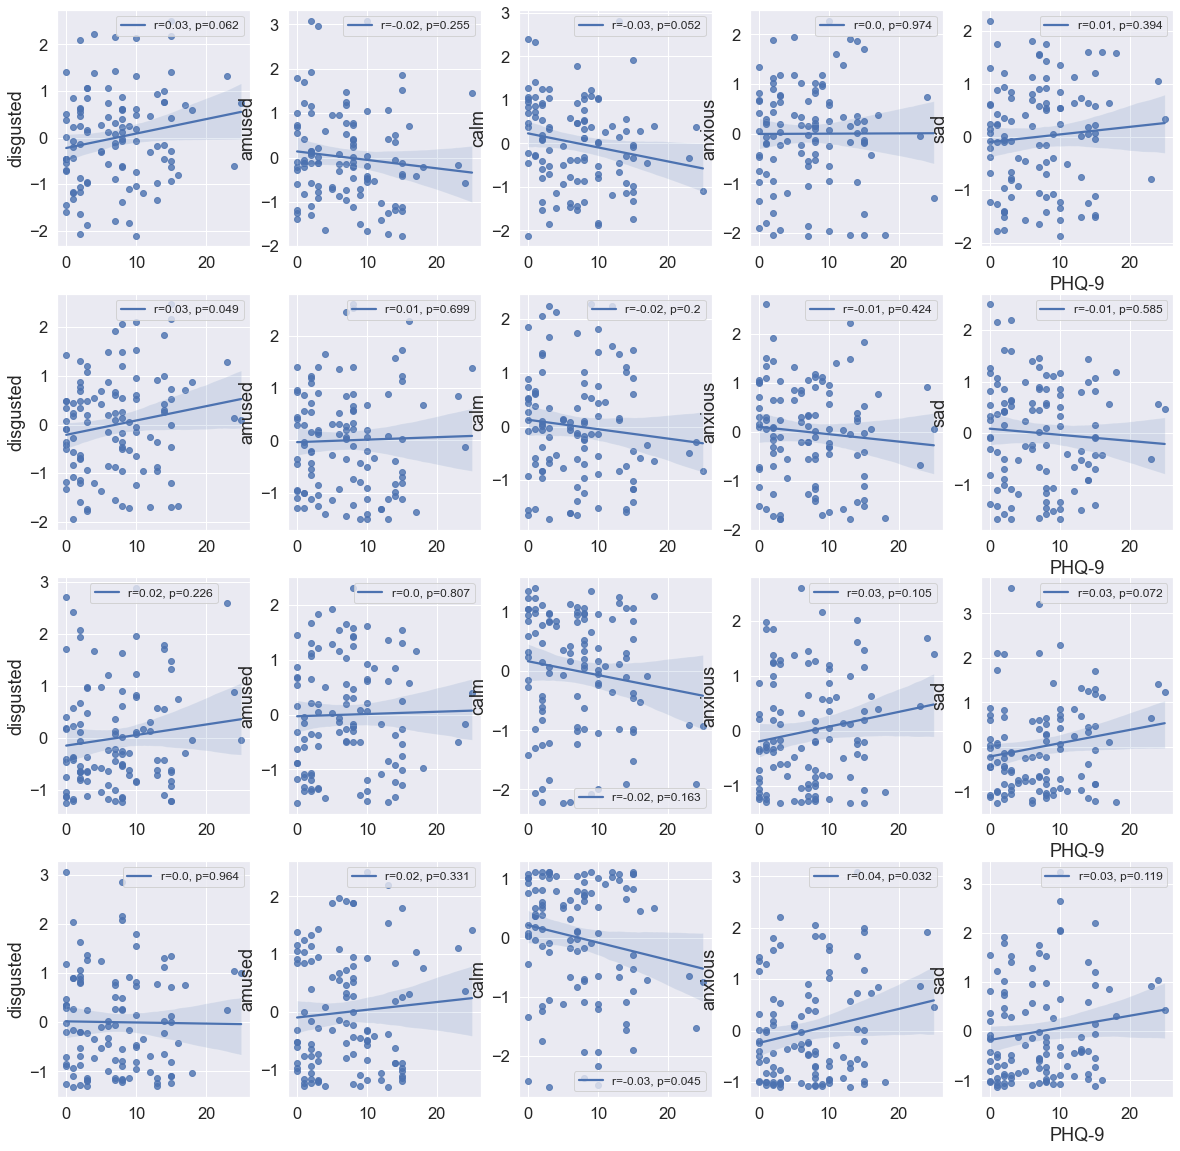

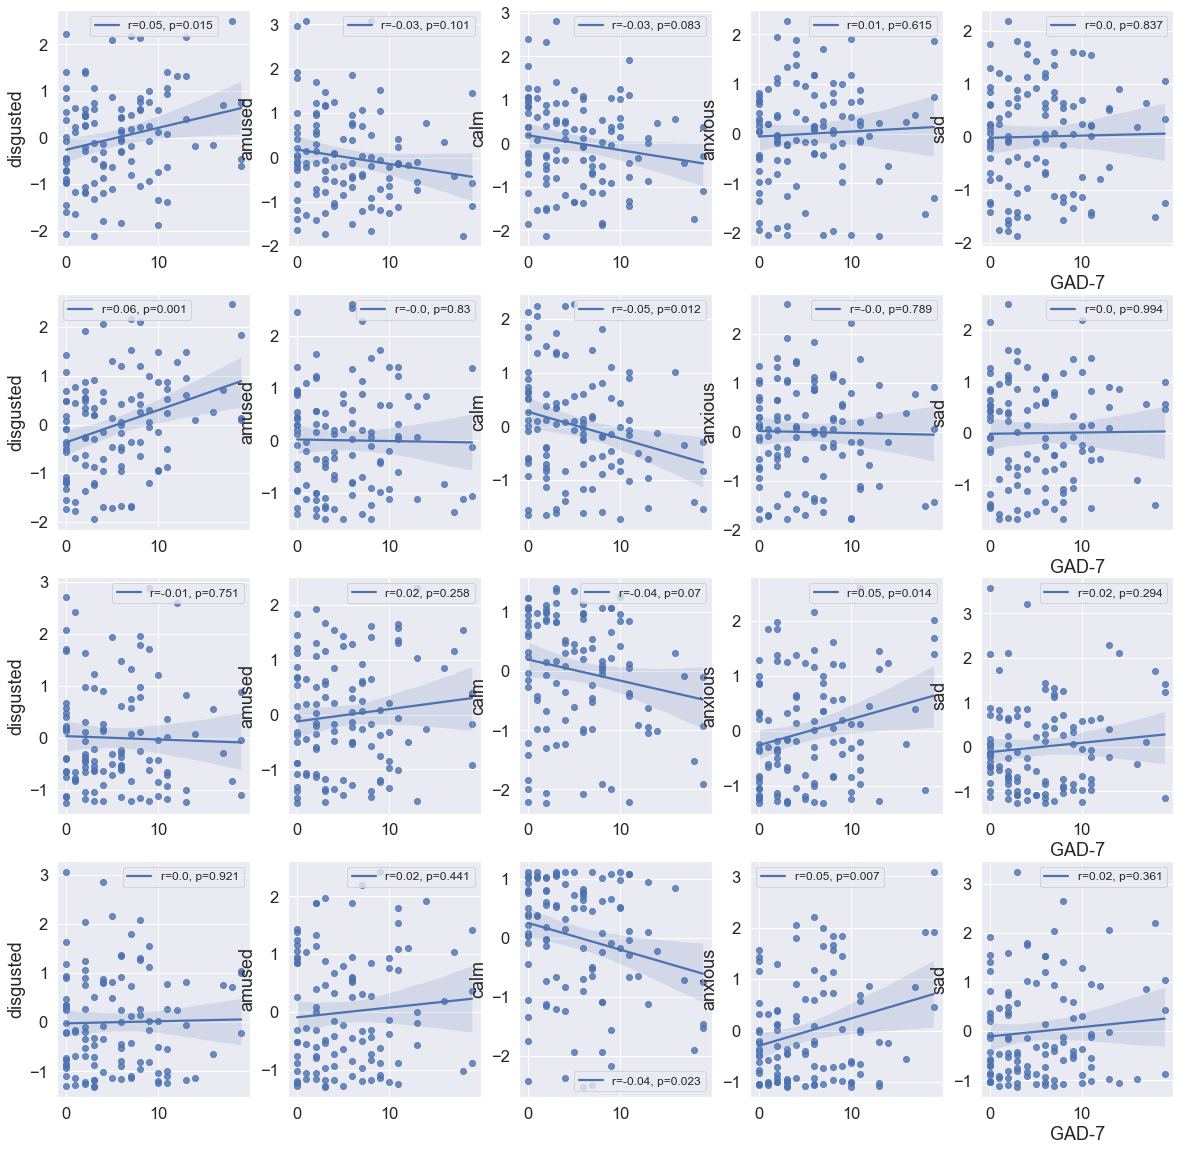

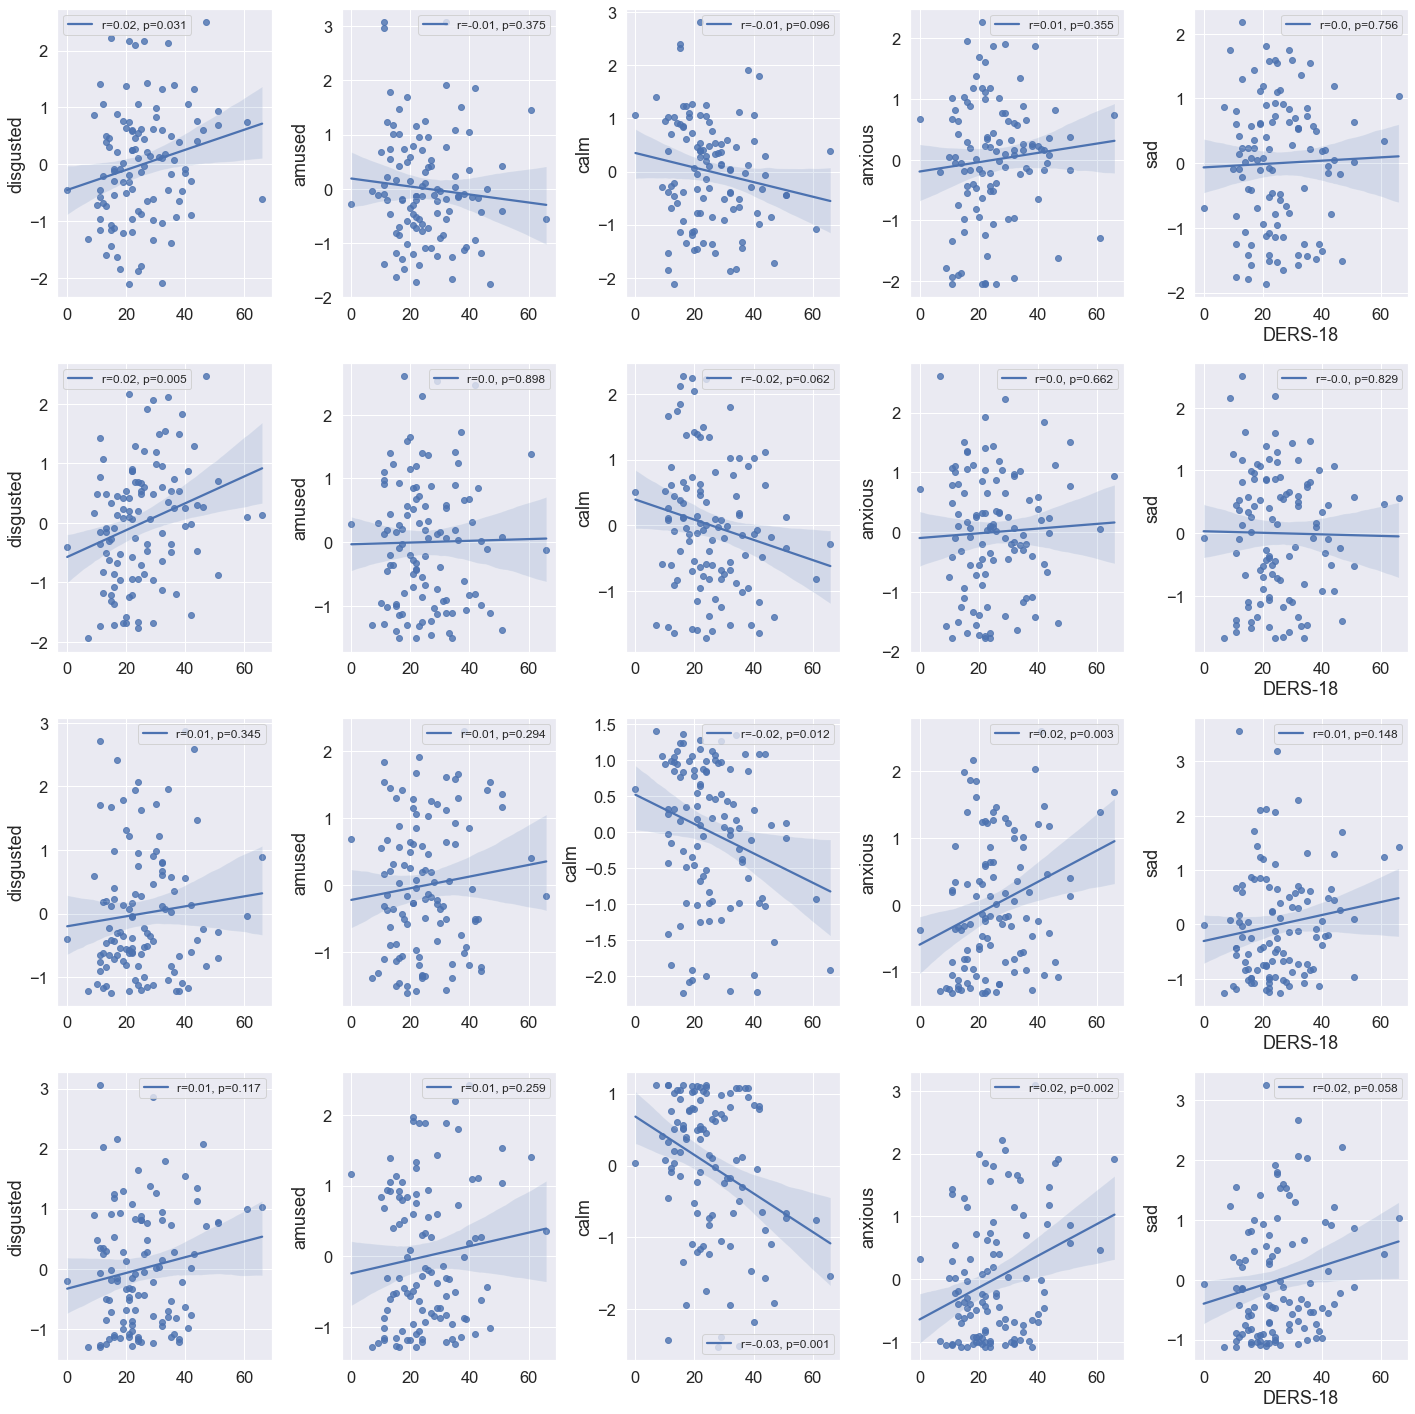

In [27]:
questionnaire_label = ['PHQ-9', 'GAD-7', 'DERS-18']
for r, q in enumerate(questionnaires):
    fig,axs= plt.subplots(len(timing), len(mood_categories), figsize=(20,20))
    grid = plt.GridSpec(len(timing), len(mood_categories))
    for m,t in enumerate(timing):
        c = [i for i in df_mood.columns if t in i]
        for n,cc in enumerate(c):
            slope = df_stats_all[r][(mood_categories[n],'coef')].loc[q + ' -> ' + t]
            p_value = df_stats_all[r][(mood_categories[n],'P>|z|')].loc[q + ' -> ' + t]
            b = sns.regplot(data = df_mood, x=q, y=cc, ax=axs[m,n], \
                            line_kws={'label': 'r=' + str(np.round(slope,2)) + ', p=' + str(p_value)})
            b.legend(prop={'size': 12})
            if n == len(timing): b.set(xlabel=questionnaire_label[r])
            else: b.set(xlabel='')
            b.set(ylabel=mood_categories[n])
#         create_subtitle(fig, grid[m, ::], list(timing.keys())[m])
plt.tight_layout()